# QuadProg to draw Efficient Frontier 

In [79]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import edhec_risk_kit as erk

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
ind = erk.get_ind_returns()
er = erk.annualized_return(ind["1996":"2000"], 12)
cov = ind['1996':'2000'].cov()

In [6]:
def portfolio_return(weights, returns):
    """
    Weights -> Returns
    """
    return weights.T @ returns

def porfolio_vol(weights, covmat):
    """
    Weight -> Vol
    """
    return (weights.T @ covmat @ weights)**0.5

In [7]:
assets = ["Food", "Beer", "Smoke", "Coal"]

In [9]:
er[assets]

Food     0.116799
Beer     0.141126
Smoke    0.107830
Coal     0.414689
dtype: float64

In [10]:
cov.loc[assets, assets]

,Food,Beer,Smoke,Coal
Food,0.002609,0.002379,0.002061,0.000027
Beer,0.002379,0.005264,0.001359,0.001728
Smoke,0.002061,0.001359,0.008349,-0.000733
Coal,0.000027,0.001728,-0.000733,0.018641


In [14]:
import numpy as np
weights = np.repeat(1/4, 4)
weights

array([0.25, 0.25, 0.25, 0.25])

In [15]:
erk.portfolio_return(weights, er[assets])

0.19511097196038385

In [16]:
erk.porfolio_vol(weights, cov.loc[assets, assets])

0.055059195776437045

# 2-Asset Frontier

In [17]:
l = ["Games", "Fin"]

In [19]:
n_points = 20
weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]

In [24]:
weights

[array([0., 1.]),
 array([0.05263158, 0.94736842]),
 array([0.10526316, 0.89473684]),
 array([0.15789474, 0.84210526]),
 array([0.21052632, 0.78947368]),
 array([0.26315789, 0.73684211]),
 array([0.31578947, 0.68421053]),
 array([0.36842105, 0.63157895]),
 array([0.42105263, 0.57894737]),
 array([0.47368421, 0.52631579]),
 array([0.52631579, 0.47368421]),
 array([0.57894737, 0.42105263]),
 array([0.63157895, 0.36842105]),
 array([0.68421053, 0.31578947]),
 array([0.73684211, 0.26315789]),
 array([0.78947368, 0.21052632]),
 array([0.84210526, 0.15789474]),
 array([0.89473684, 0.10526316]),
 array([0.94736842, 0.05263158]),
 array([1., 0.])]

In [27]:
rets = [erk.portfolio_return(w, er[l]) for w in weights]
vols = [erk.porfolio_vol(w, cov.loc[l,l]) for w in weights]

In [28]:
import pandas as pd

In [29]:
ef = pd.DataFrame({"R": rets, "Vol": vols})

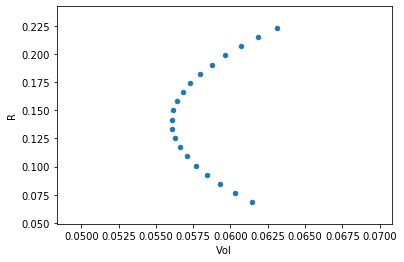

In [34]:
ef.plot.scatter(x="Vol", y="R")

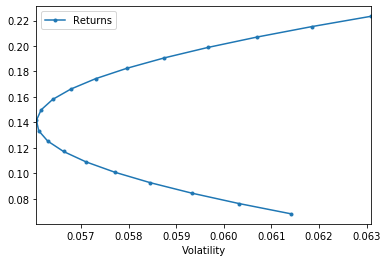

In [41]:
erk.plot_ef2(n_points, er[l], cov.loc[l,l])

# N-Asset Efficient Frontier

```python
def plot_ef(n_points, er, cov, style=".-"):
    """
    Plots the 2-asset efficient frontier
    """
    weights = minimize_vol(target_return)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [porfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets,
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style=style)
```

In [43]:
from scipy.optimize import minimize

In [44]:
l

['Games', 'Fin']

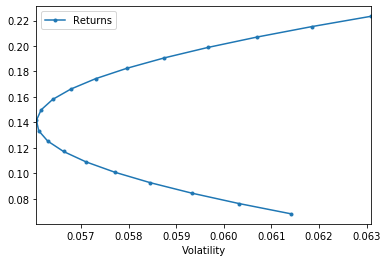

In [47]:
erk.plot_ef2(20, er[l], cov.loc[l,l])

In [62]:
def minimize_vol(target_return, er, cov):
    """
    Target return -> Weight vector
    """
    n_assets = er.shape[0]
    init_guess = np.repeat(1/n_assets, n_assets)
    bounds = ((0.0, 1.0),)*n_assets
    return_is_target = {
        'type': 'eq',
        'args': (er,),
        'fun': lambda weights, er: target_return - erk.portfolio_return(weights, er)
    }
    weights_sum_to_1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }
    results = minimize(erk.porfolio_vol,
                        init_guess,
                        args=(cov,), 
                        method="SLSQP",
                        constraints=(return_is_target, weights_sum_to_1),
                        bounds=bounds)
    return results.x
    

In [96]:
w15 = erk.minimize_vol(0.1455, er[l], cov.loc[l,l])

In [97]:
vol15 = erk.porfolio_vol(w15, cov.loc[l,l])
vol15

0.05609066849341863

In [98]:
w15

array([0.50187865, 0.49812135])

In [112]:
def optimal_weights(n_points, er, cov):
    """
    Generate a list of weights to run the optimizer on
    """
    target_returns = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_returns]
    return weights
    
def plot_ef(n_points, er, cov, style=".-"):
    """
    Plots the 2-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [porfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets,
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style=style, title="Multi-asset Efficient Frontier")

In [113]:
k = ["Smoke", "Fin", "Games", "Coal", ]

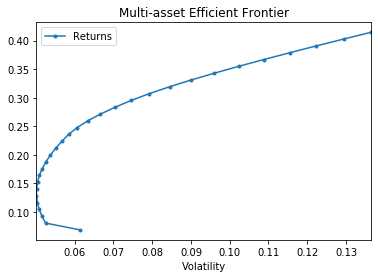

In [114]:
plot_ef(30, er[k], cov.loc[k,k], )

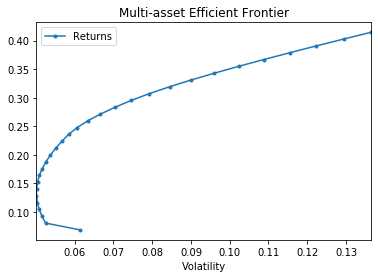

In [115]:
erk.plot_ef(30, er[k], cov.loc[k,k], )

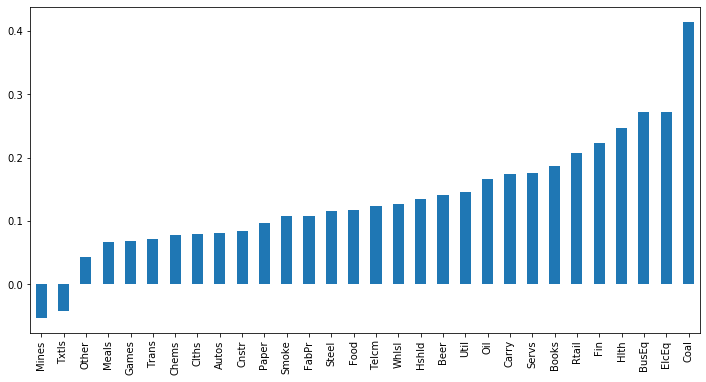

In [120]:
er.sort_values().plot.bar(figsize=(12,6))

In [121]:
k = ["Coal", "Fin", "Mines", "Food", "Oil", "Beer", "Food"]

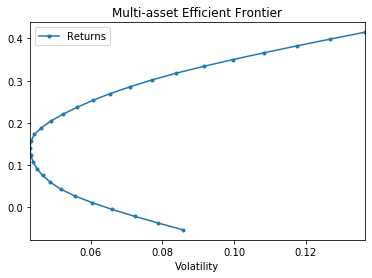

In [122]:
erk.plot_ef(30, er[k], cov.loc[k,k], )

In [128]:
er.sort_values()

Mines   -0.053554
Txtls   -0.042721
Other    0.043349
Meals    0.067400
Games    0.068212
Trans    0.071099
Chems    0.077456
Clths    0.079160
Autos    0.080954
Cnstr    0.084076
Paper    0.097163
Smoke    0.107830
FabPr    0.108280
Steel    0.115809
Food     0.116799
Telcm    0.122771
Whlsl    0.126431
Hshld    0.134766
Beer     0.141126
Util     0.145903
Oil      0.165377
Carry    0.173904
Servs    0.175264
Books    0.187286
Rtail    0.207247
Fin      0.223371
Hlth     0.246641
BusEq    0.271952
ElcEq    0.272420
Coal     0.414689
dtype: float64